## Imports

In [1]:
import tensorflow as tf
import os
import random
import shutil
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Subtract, Lambda,concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
import keras.backend as K

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from imutils import face_utils

import imutils
import dlib
import cv2
from google.colab.patches import cv2_imshow
from collections import OrderedDict



## Data wrangling (setting up the train, test, val generators etc.)

https://drive.google.com/file/d/1QGPPQQ7OxDKPfKssrLb4x7Ql7jvFWXLk/view?usp=share_link NOTE DOWNLOAD THIS FILE AS KAGGLE.json and put it in the current directory and run the following cell to download the original data

In [16]:
def get_data():
    ! mkdir -p ~/.kaggle
    ! cp ./kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json 
    import kaggle
    
    ! kaggle datasets download -d ciplab/real-and-fake-face-detection
    try:
        from zipfile import ZipFile
    except ImportError:
        return
    
    fname = "/content/real-and-fake-face-detection.zip"

    with ZipFile(fname,'r') as zip:
        zip.extractall()
    
    print('Done Extracting data')


In [17]:
get_data()

 99% 428M/431M [00:06<00:00, 90.5MB/s]
100% 431M/431M [00:06<00:00, 69.4MB/s]
Done Extracting data


In [18]:
def train_test_val():
    path='Data/'

    #if files already exist, remove all the data in them
    try:
        os.mkdir('Data/')
    except FileExistsError:
        !rm 'Data/' -r
    
    !mkdir 'Data/'
    !mkdir 'Data/Train/'
    !mkdir 'Data/Train/Fake/'
    !mkdir 'Data/Train/Real/'
    !mkdir 'Data/Test/'
    !mkdir 'Data/Test/Fake/'
    !mkdir 'Data/Test/Real/'
    !mkdir 'Data/Val/'
    !mkdir 'Data/Val/Fake/'
    !mkdir 'Data/Val/Real/'


    # Now need to move files around
    # We'll use a 70 15 15 split, 70% training data, 15% validation data, 15% testing data
    
    # Fake
    src_fake = '/content/real_and_fake_face/training_fake/'
    dst_train_fake = '/content/Data/Train/Fake/'
    dst_test_fake = '/content/Data/Test/Fake/'
    dst_val_fake = '/content/Data/Val/Fake/'

    #so there are 960 total images that are fake, so 70% of that is 672
    # 15% of 960 is 144
    # So for list slicing our training fake data will be 0:672
    # our test fake data will be 673:816
    # and our val fake data will be 817:

    fake_imgs = os.listdir(src_fake)
    np.random.shuffle(fake_imgs)
    
    train_fake_imgs = fake_imgs[0:672] #70%
    test_fake_imgs = fake_imgs[673:816] #~15%
    val_fake_imgs = fake_imgs[817:] #~15%
    
    # Real
    src_real = '/content/real_and_fake_face/training_real/'
    dst_train_real = '/content/Data/Train/Real/'
    dst_test_real = '/content/Data/Test/Real/'
    dst_val_real = '/content/Data/Val/Real/'

    # so there is 1081 real images in training_real folder. so 70% of that is 757
    # 324 of that is reamining, and we split it equally (15% and 15%) meaning 162 and 162 will be
    # for validation and test sets.
    # 757 + 162 + 162 = 1081
    # 0:756 will be train
    # 757:919 will be val
    # 919: will be test

    real_imgs = os.listdir(src_real)
    np.random.shuffle(real_imgs)

    train_real_imgs = real_imgs[0:756] #70%
    test_real_imgs = real_imgs[757:919] #15%
    val_real_imgs = real_imgs[919:] #15%

    # using shutil.move()
    print('Moving real images...')
    [shutil.move(src=os.path.join(src_real, file), dst=os.path.join(dst_train_real, file)) for file in train_real_imgs]
    [shutil.move(src=os.path.join(src_real, file), dst=os.path.join(dst_test_real, file)) for file in test_real_imgs]
    [shutil.move(src=os.path.join(src_real, file), dst=os.path.join(dst_val_real, file)) for file in val_real_imgs]
    print('Done moving real imgs')

    print('Moving fake imgs...')
    [shutil.move(src=os.path.join(src_fake, file), dst=os.path.join(dst_train_fake, file)) for file in train_fake_imgs]
    [shutil.move(src=os.path.join(src_fake, file), dst=os.path.join(dst_test_fake, file)) for file in test_fake_imgs]
    [shutil.move(src=os.path.join(src_fake, file), dst=os.path.join(dst_val_fake, file)) for file in val_fake_imgs]
    print('Done moving fake imgs')

    print(f'Size of train fake dir: {len(os.listdir(dst_train_fake))}')
    print(f'Size of test fake dir: {len(os.listdir(dst_test_fake))}')
    print(f'Size of val fake dir: {len(os.listdir(dst_val_fake))}')
    print(f'Size of train real dir: {len(os.listdir(dst_train_real))}')
    print(f'Size of test real dir: {len(os.listdir(dst_test_real))}')
    print(f'Size of val real dir: {len(os.listdir(dst_val_real))}')

    # remove empty folder now
    ! rm /content/real_and_fake_face -r

In [19]:
train_test_val()

mkdir: cannot create directory ‘Data/’: File exists
Moving real images...
Done moving real imgs
Moving fake imgs...
Done moving fake imgs
Size of train fake dir: 672
Size of test fake dir: 143
Size of val fake dir: 143
Size of train real dir: 756
Size of test real dir: 162
Size of val real dir: 162


In [20]:
train_dir = '/content/Data/Train/'
test_dir = '/content/Data/Test/'
val_dir = '/content/Data/Val/'

#### NOTE preprocessed data
This cell needs the preprocessed.tar.gz file from the data.txt to be uploaded to the current directory. The preprocessed data has the resulting images after detecting the bounding boxes of left eye and right eye. This process takes a while to run so we created a compressed archive from which it could be loaded.

In [21]:
# loading preprocessed data
!gzip -d preprocessed.tar.gz && tar -xvf preprocessed.tar

gzip: preprocessed.tar.gz: No such file or directory


In [8]:
!mkdir -p detector_models && wget -P ./detector_models 'https://github.com/davisking/dlib-models/raw/master/shape_predictor_5_face_landmarks.dat.bz2' 
!bzip2 -d '/content/detector_models/shape_predictor_5_face_landmarks.dat.bz2'

--2022-11-16 00:18:12--  https://github.com/davisking/dlib-models/raw/master/shape_predictor_5_face_landmarks.dat.bz2
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_5_face_landmarks.dat.bz2 [following]
--2022-11-16 00:18:12--  https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_5_face_landmarks.dat.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M) [application/octet-stream]
Saving to: ‘./detector_models/shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  --.-KB

In [22]:


# returns the left eye and right eye of the image using opencv
def preprocess(path:str,store_path:str):
  img_name = os.path.basename(path).split('.')[0]
  #detector = dlib.cnn_face_detection_model_v1('/content/detector_models/dlib_face_recognition_resnet_model_v1.dat')
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor('/content/detector_models/shape_predictor_5_face_landmarks.dat')
  # load the input image, resize it, and convert it to grayscale
  image = cv2.imread(path)
  image = imutils.resize(image, width=500)
  rects = detector(image, 1)
  if not len(rects)==1:
    print(f"{len(rects)} faces detected in {path} so skipping")
    return
  top_right,bottom_left = (rects[0].right(),rects[0].top()),(rects[0].left(),rects[0].bottom())
  cv2.rectangle(image,top_right,bottom_left,(255,0,0))
  shape = predictor(image, rects[0])
  shape = face_utils.shape_to_np(shape)
  if not len(shape)==5:
    print(f"Insufficient landmarks detected in {path} so skipping")
    return
  nose_point = shape[-1] # Contour point for bottom of nose
  eye_box_height = nose_point[1]//8
  right_eye_top_left = (shape[1][0],shape[1][1]+eye_box_height)
  right_eye_bottom_right = (shape[0][0],shape[0][1]-eye_box_height)
  cv2.rectangle(image,right_eye_top_left,right_eye_bottom_right,(255,0,0))
  left_eye_top_left = (shape[2][0],shape[2][1]+eye_box_height)
  left_eye_bottom_right = (shape[3][0],shape[3][1]-eye_box_height)
  cv2.rectangle(image,left_eye_top_left,left_eye_bottom_right,(255,0,0))
  left_eye_save = image[left_eye_bottom_right[1]:left_eye_top_left[1],left_eye_top_left[0]:left_eye_bottom_right[0]]
  right_eye_save = image[right_eye_bottom_right[1]:right_eye_top_left[1],right_eye_top_left[0]:right_eye_bottom_right[0]]
  left_eye_save = imutils.resize(left_eye_save,150,150)
  right_eye_save = imutils.resize(right_eye_save,150,150)
  cv2.imwrite(f"{os.path.join(store_path,img_name)}_lefteye.jpg",left_eye_save)
  cv2.imwrite(f"{os.path.join(store_path,img_name)}_righteye.jpg",right_eye_save)

In [23]:
#PREPROCESSES DATA INTO LEFT EYE AND RIGHT EYE
def create_preprocess_lib():  
  !cd './Data/' && find './' -type d -exec mkdir -p "/content/data_preprocess/{}" \;
  dirs = [train_dir,val_dir,test_dir]

  preproc_path = "/content/data_preprocess"
  for dir in dirs:
    fake_dir = os.path.join(dir,'Fake')
    real_dir = os.path.join(dir,'Real')

    stored_fake_dir = os.path.join(preproc_path,*fake_dir.split('/')[3:])
    stored_real_dir = os.path.join(preproc_path,*real_dir.split('/')[3:])
    for f in os.listdir(fake_dir):
      preprocess(os.path.join(fake_dir,f),stored_fake_dir)
    for f in os.listdir(real_dir):
      preprocess(os.path.join(real_dir,f),stored_real_dir)

In [24]:
# GENERATES A METADATA DATAFRAME FOR THE DATA GENERATOR
preproc_path = "/content/data_preprocess"
def generate_df(dir:str):
  dict = {'filename':[],
        'left_eye':[],
        'right_eye':[],
        'label':[]
       }
  metadata_df = pd.DataFrame(dict)
  fake_dir = os.path.join(dir,'Fake')
  real_dir = os.path.join(dir,'Real')

  stored_fake_dir = os.path.join(preproc_path,*fake_dir.split('/')[3:])
  stored_real_dir = os.path.join(preproc_path,*real_dir.split('/')[3:])
  for f in os.listdir(fake_dir):
    base = f.split('.')[0]
    left_eye = os.path.join(stored_fake_dir,f"{base}_lefteye.jpg")
    if not os.path.exists(left_eye):
      continue
    right_eye = os.path.join(stored_fake_dir,f"{base}_righteye.jpg")
    label = 0
    df2 = {'filename':base,'left_eye':left_eye,'right_eye':right_eye,'label':label}
    metadata_df = metadata_df.append(df2,ignore_index=True)
  for f in os.listdir(real_dir):
    base = f.split('.')[0]
    left_eye = os.path.join(stored_real_dir,f"{base}_lefteye.jpg")
    if not os.path.exists(left_eye):
      continue
    right_eye = os.path.join(stored_real_dir,f"{base}_righteye.jpg")
    label = 1
    df2 = {'filename':base,'left_eye':left_eye,'right_eye':right_eye,'label':label}
    metadata_df = metadata_df.append(df2,ignore_index=True)
  return metadata_df

## Siamese Network

In [25]:
# CREATING A metadata dataframe for the data
import pandas as pd
train_df = generate_df(train_dir)
val_df = generate_df(val_dir)
test_df = generate_df(test_dir)




In [26]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(66, 100, 3),
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_type = df[y_col['label']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path, target_size):

        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()

        return image_arr/255.
    
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        left_eye_batch = batches[self.X_col['left_eye']]
        right_eye_batch = batches[self.X_col['right_eye']]


        label_batch = batches[self.y_col['label']]

        XL_batch = np.asarray([self.__get_input(x,self.input_size) for x in left_eye_batch])
        XR_batch = np.asarray([self.__get_input(x,self.input_size) for x in right_eye_batch])
        y_batch = np.asarray([self.__get_output(y, self.n_type) for y in label_batch])

        return tuple([XL_batch,XR_batch]),y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return (self.n // self.batch_size)+1

In [27]:
train_gen = CustomDataGen(
    df=train_df,
    X_col={'left_eye':'left_eye', 'right_eye': 'right_eye'},
    y_col={'label':'label'},
    batch_size = 16,
    input_size = (66,100,3)
)

val_gen = CustomDataGen(
    df=val_df,
    X_col={'left_eye':'left_eye', 'right_eye': 'right_eye'},
    y_col={'label':'label'},
    batch_size = 16,
    input_size = (66,100,3)
)

test_gen = CustomDataGen(
 df = test_df,
 X_col={'left_eye':'left_eye', 'right_eye': 'right_eye'},
 y_col={'label':'label'},
 batch_size = 16,
 input_size = (66,100,3),
 shuffle=False
)

In [14]:
input_shape = (66,100,3)
learning_rate = 0.0001
siamese_net = Sequential()
siamese_net.add(Conv2D(filters=64, kernel_size=(10, 10),
                              activation='relu',
                              input_shape=input_shape,
                              name='Conv1'))
siamese_net.add(MaxPool2D())

siamese_net.add(Conv2D(filters=128, kernel_size=(7, 7),
                              activation='relu',
                              name='Conv2'))
siamese_net.add(MaxPool2D())

siamese_net.add(Conv2D(filters=128, kernel_size=(4, 4),
                              activation='relu',
                              name='Conv3'))
siamese_net.add(MaxPool2D())

siamese_net.add(Conv2D(filters=256, kernel_size=(4, 4),
                              activation='relu',
                              kernel_regularizer=l2(
                                  1e-4),
                              name='Conv4'))

siamese_net.add(Flatten())
siamese_net.add(
    Dense(units=2048, activation='relu',
          name='Dense1'))

# Now the pairs of images
input_image_1 = Input(input_shape)
input_image_2 = Input(input_shape)

encoded_image_1 = siamese_net(input_image_1)
encoded_image_2 = siamese_net(input_image_2)

# # L1 distance layer between the two encoded outputs
# # One could use Subtract from Keras, but we want the absolute value

l1_distance_layer = Lambda(
    lambda tensors: K.abs(tensors[0] - tensors[1]))
l1_distance = l1_distance_layer([encoded_image_1, encoded_image_2])

concated = concatenate([encoded_image_1,encoded_image_2,l1_distance])
out_1 = Flatten()(concated)
output_layer = Dense(units=2,activation="softmax")(out_1)



# Same class or not prediction
#prediction = Dense(units=1, activation='sigmoid')(l1_distance)




siamese_model = Model(
    inputs=[input_image_1, input_image_2], outputs=output_layer)

# Define the optimizer and compile the model
optimizer = Adam(
    learning_rate=learning_rate)  

siamese_model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                    optimizer=optimizer)


In [41]:
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 66, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 66, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential (Sequential)        (None, 2048)         3831104     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

#### NOTE LOAD MODEL FROM CHECKPOINT FOLDER GIVEN IN MODELS.TXT

In [21]:
#load weights from saved model
siamese_model.load_weights('./siamese_model/')

In [16]:
# IN CASE you want to train the model
result=siamese_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10
60/60 [==============================] - 13s 74ms/step - loss: 0.7230 - accuracy: 0.4607 - val_loss: 0.7076 - val_accuracy: 0.4878
Epoch 2/10
60/60 [==============================] - 4s 68ms/step - loss: 0.7062 - accuracy: 0.5310 - val_loss: 0.7052 - val_accuracy: 0.5122
Epoch 3/10
60/60 [==============================] - 4s 67ms/step - loss: 0.7045 - accuracy: 0.5215 - val_loss: 0.7036 - val_accuracy: 0.4878
Epoch 4/10
60/60 [==============================] - 4s 70ms/step - loss: 0.7026 - accuracy: 0.5310 - val_loss: 0.7030 - val_accuracy: 0.4878
Epoch 5/10
60/60 [==============================] - 4s 74ms/step - loss: 0.6942 - accuracy: 0.5498 - val_loss: 0.7027 - val_accuracy: 0.6098
Epoch 6/10
60/60 [==============================] - 4s 70ms/step - loss: 0.6762 - accuracy: 0.5876 - val_loss: 0.7035 - val_accuracy: 0.5854
Epoch 7/10
60/60 [==============================] - 4s 71ms/step - loss: 0.6574 - accuracy: 0.6044 - val_loss: 0.7835 - val_accuracy: 0.5122
Epoch 8/10
6

<Figure size 432x288 with 0 Axes>

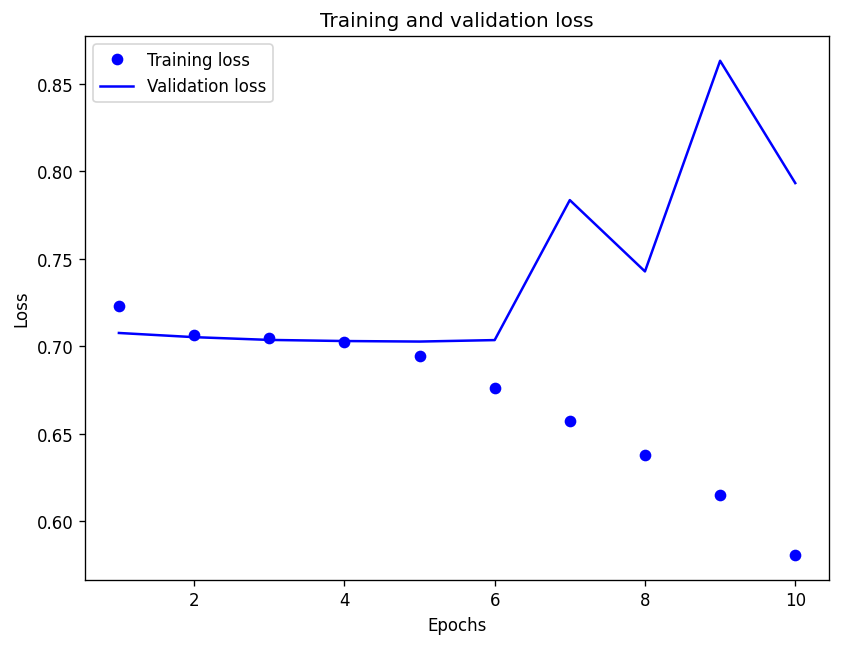

<Figure size 432x288 with 0 Axes>

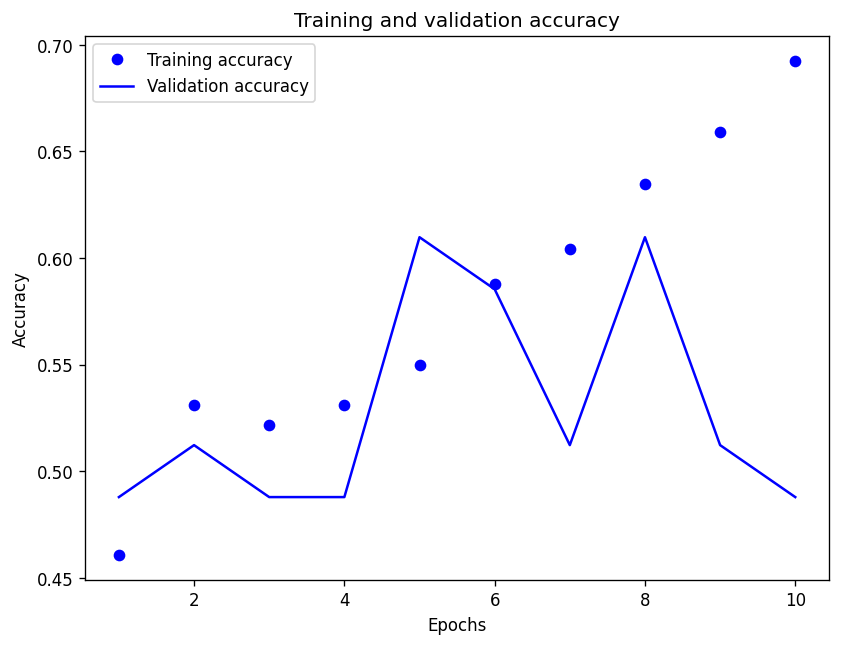

In [17]:
plt.clf()
plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
loss = result.history['loss']
val_loss = result.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'bo',label='Training loss') # blue dots
plt.plot(epochs,val_loss,'b',label='Validation loss') # blue line
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.clf()
plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k') 
acc_values = result.history['accuracy']
val_acc_values = result.history['val_accuracy']
plt.plot(epochs,acc_values,'bo',label='Training accuracy')
plt.plot(epochs,val_acc_values,'b',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
siamese_model.evaluate_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.7340672612190247, 0.557692289352417]

In [28]:
y_preds = siamese_model.predict(test_gen)

4/4 [==============================] - 0s 39ms/step


In [29]:
y_true = test_df['label']

In [35]:
y_preds=np.argmax(y_preds,axis=1)

Balanced Accuracy Score: 0.5565476190476191


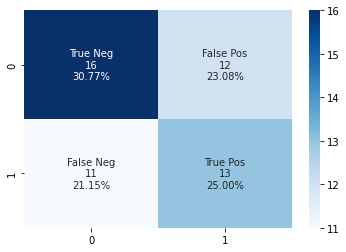

In [36]:
import sklearn.metrics as sm
import seaborn as sns
def confusion_matrix_balanced_acc(y_true, y_preds):
  cnfmtrx = sm.confusion_matrix(y_true=y_true, y_pred=y_preds)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cnfmtrx.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cnfmtrx.flatten()/np.sum(cnfmtrx)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cnfmtrx, annot=labels, fmt='', cmap='Blues')

  print(f'Balanced Accuracy Score: {sm.balanced_accuracy_score(y_true, y_preds)}')

confusion_matrix_balanced_acc(y_true,y_preds)